cpu
Downsampled MNIST tensor shape: torch.Size([14, 14])


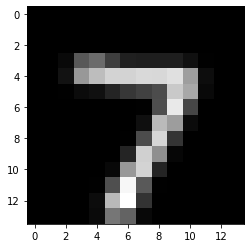

In [1]:
import os
import numpy as np
import time 
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader  # PyG Data and loader
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

test_features, test_labels = next(iter(test_loader))
true = test_features[0].squeeze()
plt.imshow(true, cmap="gray")
print(f"Downsampled MNIST tensor shape: {true.shape}")

# Set up MLP class an do Git Rebasin on 1200 saved MLPs
To-do: Also do a scale canonicalization like Ege

In [2]:
# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
def test_mlp(model, test_loader, device = device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

In [3]:
# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """Permutes weights and biases of a layer based on the given permutation matrix."""
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """Applies a list of permutations to a model's layers."""
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input wei
    ghts of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """Generates a random permutation matrix."""
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    Optimizes permutations to match Model B to Model A.
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score

def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

def get_permuted_models_data(ref_point=0, N = 10, path = f"models/reduced_mlp_weights_{0}.pt"):
    ref_model = MLP()
    ref_model_path = path #f"models/reduced_mlp_weights_{ref_point}.pt"
#     ref_model_path =   f"models/dropout_mlp_weights_{ref_point}.pt"

    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/reduced_mlp_weights_{i}.pt"
#         model_path = f"models/dropout_mlp_weights_{i}.pt"
        
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times


In [4]:
org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 1200) 

# PyG Graph Dataset and Dataloader for MLPs
Like Ege's thesis, each neuron is a node with bias values, the edges are weights with weight values

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

###############################
# 1. Dataset: Neuron-level Graph Representation
###############################
# class MLPGraphDatasetNeurons(torch.utils.data.Dataset):
#     def __init__(self, model_folder):
#         # Collect all .pt files in the folder.
#         self.model_paths = [os.path.join(model_folder, fname) 
#                             for fname in os.listdir(model_folder) if fname.endswith('.pt')]

#     def __len__(self):
#         return len(self.model_paths)

#     def __getitem__(self, idx):
#         # Each file stores (weights, biases) using weights_only=True.
#         weights, biases = torch.load(self.model_paths[idx], weights_only=True)
#         # --- Build Node Features ---
#         # Input layer: use the input dimension from the first weight matrix.
#         input_dim = weights[0].shape[1]
#         input_feats = torch.zeros(input_dim, 1)
#         node_features = [input_feats]
#         for b in biases:
#             # Each bias is a 1D tensor; reshape it as a column vector.
#             node_feats = b.view(-1, 1)
#             node_features.append(node_feats)
#         x = torch.cat(node_features, dim=0)

#         # --- Build Edges and Edge Attributes ---
#         edge_index_list = []
#         edge_attr_list = []
#         offset = 0  # starting index for current layer's nodes
#         for w in weights:
#             in_dim = w.shape[1]    # nodes in source layer
#             out_dim = w.shape[0]   # nodes in destination layer
#             src_offset = offset
#             dst_offset = offset + in_dim
#             for i_out in range(out_dim):
#                 for j_in in range(in_dim):
#                     src = src_offset + j_in
#                     dst = dst_offset + i_out
#                     edge_index_list.append([src, dst])
#                     edge_attr_list.append([w[i_out, j_in].item()])
#             offset += in_dim
#         # Convert lists into tensors.
#         edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
#         edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
#         return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

class MLPGraphDatasetNeuronsFromList(torch.utils.data.Dataset):
    def __init__(self, mlp_list):
        """
        mlp_list: a list of MLP objects.
        """
        self.models = mlp_list

    def __len__(self):
        return len(self.models)

    def __getitem__(self, idx):
        # Get the MLP instance from the list.
        mlp = self.models[idx]
        # Extract weights and biases directly from the model's layers.
        # We assume the model has attributes fc1, fc2, fc3.
        weights = [mlp.fc1.weight, mlp.fc2.weight, mlp.fc3.weight]
        biases = [mlp.fc1.bias, mlp.fc2.bias, mlp.fc3.bias]

        # --- Build Node Features ---
        # Input layer: create nodes based on the input dimension of fc1.
        input_dim = weights[0].shape[1]
        input_feats = torch.zeros(input_dim, 1)
        # For subsequent layers, use the bias of each layer as the node feature.
        node_features = [input_feats]
        for b in biases:
            node_feats = b.view(-1, 1)
            node_features.append(node_feats)
        # Concatenate features from all layers; total nodes = input_dim + sum(layer output sizes)
        x = torch.cat(node_features, dim=0)

        # --- Build Edges and Edge Attributes ---
        edge_index_list = []
        edge_attr_list = []
        offset = 0  # starting index for current layer's nodes
        # Iterate over each weight matrix corresponding to a layer.
        for w in weights:
            in_dim = w.shape[1]    # number of nodes in source layer
            out_dim = w.shape[0]   # number of nodes in destination layer
            src_offset = offset
            dst_offset = offset + in_dim
            for i_out in range(out_dim):
                for j_in in range(in_dim):
                    src = src_offset + j_in
                    dst = dst_offset + i_out
                    edge_index_list.append([src, dst])
                    edge_attr_list.append([w[i_out, j_in].item()])
            offset += in_dim  # move the offset for the next layer

        # Convert lists to torch tensors.
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

# outdated function name, still works nicely though.
def vgae_to_mlp(generated_data):
    """
    generated_data: a Data object that has the reconstructed node features (x)
    and edge attributes (edge_attr).  
    The original graph was built as:
      - First 196 nodes: input layer,
      - Next 32 nodes: fc1 neurons,
      - Next 32 nodes: fc2 neurons,
      - Next 10 nodes: fc3 neurons.
    Edge ordering is:
      - fc1: edges from input (196 nodes) to fc1 (32 nodes) in a nested loop:
             for i in range(32): for j in range(196)
      - fc2: edges from fc1 (32 nodes) to fc2 (32 nodes)
      - fc3: edges from fc2 (32 nodes) to fc3 (10 nodes)
    This function instantiates a new MLP and sets its weights and biases from the generated outputs.
    """
    x_rec = generated_data.x.squeeze()  # shape: (196+32+32+10,)
    edge_attr_rec = generated_data.edge_attr  # shape: (32*196 + 32*32 + 10*32,)

    # Extract biases.
    fc1_bias = x_rec[196:196+32]
    fc2_bias = x_rec[196+32:196+32+32]
    fc3_bias = x_rec[196+32+32:196+32+32+10]

    # Extract edge weights.
    # For fc1: first 32*196 values.
    fc1_weight = edge_attr_rec[:32*196].view(32, 196)
    # For fc2: next 32*32 values.
    start_fc2 = 32*196
    fc2_weight = edge_attr_rec[start_fc2:start_fc2+32*32].view(32, 32)
    # For fc3: remaining 10*32 values.
    start_fc3 = start_fc2 + 32*32
    fc3_weight = edge_attr_rec[start_fc3:start_fc3+10*32].view(10, 32)

    # Create a new instance of the MLP.
    new_mlp = MLP()
    # Assign weights and biases.
    with torch.no_grad():
        new_mlp.fc1.weight.copy_(fc1_weight)
        new_mlp.fc1.bias.copy_(fc1_bias)
        new_mlp.fc2.weight.copy_(fc2_weight)
        new_mlp.fc2.bias.copy_(fc2_bias)
        new_mlp.fc3.weight.copy_(fc3_weight)
        new_mlp.fc3.bias.copy_(fc3_bias)
    return new_mlp


# Denoising Graph AutoEncoder
Could be beefier, but should be more than enough for only MNIST MLPs

In [6]:
from torch_geometric.nn import NNConv, GraphNorm, GraphSAGE, SAGEConv, GraphSAGE

class EdgeConditionedEncoder(nn.Module):
    def __init__(self, in_ch, hidden_ch, latent_dim, num_sage_pre=1, num_sage_post=1):
        super().__init__()
        # --- GraphSAGE pre-stack: in_ch -> hidden_ch
        self.sage_pre = nn.ModuleList([
            SAGEConv(in_ch if i==0 else hidden_ch, hidden_ch)
            for i in range(num_sage_pre)
        ])
        # --- First NNConv: hidden_ch -> hidden_ch
        self.edge_mlp1 = nn.Sequential(
            nn.Linear(1, hidden_ch * hidden_ch),
            nn.ReLU(),
            nn.Linear(hidden_ch * hidden_ch, hidden_ch * hidden_ch)
        )
        self.conv1 = NNConv(hidden_ch, hidden_ch, self.edge_mlp1, aggr='mean')
        self.norm1 = GraphNorm(hidden_ch)

        # --- Second NNConv: hidden_ch -> hidden_ch
        self.edge_mlp2 = nn.Sequential(
            nn.Linear(1, hidden_ch * hidden_ch),
            nn.ReLU(),
            nn.Linear(hidden_ch * hidden_ch, hidden_ch * hidden_ch)
        )
        self.conv2 = NNConv(hidden_ch, hidden_ch, self.edge_mlp2, aggr='mean')
        self.norm2 = GraphNorm(hidden_ch)

        # --- GraphSAGE post-stack: hidden_ch -> hidden_ch
        self.sage_post = nn.ModuleList([
            SAGEConv(hidden_ch, hidden_ch)
            for _ in range(num_sage_post)
        ])

        # --- Final linear projection to latent_dim ---
        self.lin = nn.Linear(hidden_ch, latent_dim)

    def forward(self, x, edge_index, edge_weight):
        """
        x: [N, in_ch]
        edge_index: [2, E]
        edge_weight: [E] or [E,1]
        """
        # 1) Pre‐processing with GraphSAGE
        h = x
        for sage in self.sage_pre:
            h = F.relu(sage(h, edge_index))

        # reshape edge weights
        ew = edge_weight.view(-1, 1)

        # 2) First edge‐conditioned conv + norm + ReLU
        h = self.conv1(h, edge_index, ew)
        h = F.relu(self.norm1(h))

        # 3) Second edge‐conditioned conv + norm + ReLU
        h = self.conv2(h, edge_index, ew)
        h = F.relu(self.norm2(h))

        # 4) Post‐processing with GraphSAGE
        for sage in self.sage_post:
            h = F.relu(sage(h, edge_index))

        # 5) Project to latent space
        z = self.lin(h)  # [N, latent_dim]
        return z

# -----------------------------------------------------------------------------
# 3) Joint Decoder: reconstruct both edge weights & node features
# -----------------------------------------------------------------------------
class JointDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim=64):
        super().__init__()
        
        self.SAGE = GraphSAGE(latent_dim, hidden_ch*4, 2, latent_dim)
        
        # project node embeddings
        self.node_proj   = nn.Linear(latent_dim, hidden_dim)
        
        # project raw edge weights
        self.edge_proj   = nn.Linear(1, hidden_dim)
        
        # MLP heads
        self.edge_h1     = nn.Linear(hidden_dim, hidden_dim)
        self.edge_out    = nn.Linear(hidden_dim, 1)
        self.node_h1     = nn.Linear(hidden_dim, hidden_dim)
        self.node_out    = nn.Linear(hidden_dim, 1)

    def forward(self, z, edge_index, edge_weight):
        # z: [N, latent_dim]
        # edge_index: [2, E], edge_weight: [E,1] or [E]
        if edge_weight.dim() == 1:
            ew = edge_weight.unsqueeze(1)
        else:
            ew = edge_weight  # [E,1]
            
        z = self.SAGE(z, edge_index, ew)
        
        # project node embeddings
        h_n = F.relu(self.node_proj(z))           # [N, H]

        # build edge-specific features
        src, dst = edge_index
        h_e = h_n[src] + h_n[dst]                  # [E, H]
        h_ew = F.relu(self.edge_proj(ew))          # [E, H]
        h_comb = F.relu(h_e + h_ew)                # [E, H]

        # edge reconstruction
        he = F.relu(self.edge_h1(h_comb))
        edge_pred = self.edge_out(he).squeeze()    # [E]

        # node reconstruction
        hn = F.relu(self.node_h1(h_n))
        node_pred = self.node_out(hn).squeeze()    # [N]

        return edge_pred, node_pred

class GraphAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, noise_std=0.1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.noise_std = noise_std

    def forward(self, data):
        return self.encoder(data.x, data.edge_index, data.edge_attr.view(-1))

    def compute_loss(self, data):
        # encode
        z = self.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        # add Gaussian noise to latent for robustness
        if self.noise_std > 0:
            z = z + torch.randn_like(z) * self.noise_std
        # decode
        ep, npred = self.decoder(z, data.edge_index, data.edge_attr.view(-1))
        # reconstruction losses
        loss_e = F.mse_loss(ep, data.edge_attr.view(-1))
        loss_n = F.mse_loss(npred, data.x.view(-1))
        return loss_e + loss_n


## Training

In [19]:
def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

dataset = MLPGraphDatasetNeuronsFromList(permuted_models)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [20]:
in_ch = 1
hidden_ch = 16
latent_dim = 64
hidden_dim = 128

num_epochs = 25
save_every = 5

encoder = EdgeConditionedEncoder(in_ch=in_ch,   hidden_ch=hidden_ch, latent_dim=latent_dim)
decoder = JointDecoder(latent_dim=latent_dim,        hidden_dim=hidden_dim)
gae     = GraphAutoEncoder(encoder, decoder)

print(f"Denoising GAE has {count_parameters(gae)} parameters")

Denoising GAE has 193282 parameters


##### optimizer = torch.optim.Adam(gae.parameters(), lr=1e-3)
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, num_epochs + 1):
    start = time.time()
    gae.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        loss = gae.compute_loss(data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    end = time.time()
    print(f"Epoch {epoch:03d}, Recon Loss: {avg_loss:.8f}, took {(end-start):.2f}s")
    
    # checkpoint saving
    if epoch % save_every == 0:
        ckpt_path = os.path.join(checkpoint_dir, f'gae_epoch_{epoch}.pth')
        torch.save(gae.state_dict(), ckpt_path)
        print(f"[Checkpoint] Saved model at epoch {epoch} to '{ckpt_path}'")


## Loading checkpoints

gae_epoch_15.pt should be best model as of 25th April

To-Do: 
* Continue hunt for GAE improvements

In [24]:
# -----------------------------------------------------------------------------
# 7) Demonstration: loading a checkpoint
# -----------------------------------------------------------------------------
# Let's load the last saved checkpoint
checkpoint_dir = 'checkpoints'
last_checkpoint = os.path.join(checkpoint_dir, f'gae_epoch_{15}.pth')

# Re-instantiate model with same architecture
loaded_encoder = EdgeConditionedEncoder(in_ch=in_ch, hidden_ch=hidden_ch, latent_dim=latent_dim)
loaded_decoder = JointDecoder(latent_dim=latent_dim, hidden_dim=hidden_dim)
loaded_gae = GraphAutoEncoder(loaded_encoder, loaded_decoder)
loaded_gae.load_state_dict(torch.load(last_checkpoint))
loaded_gae.eval()
print(f"Loaded checkpoint from '{last_checkpoint}'")

gae = loaded_gae
# Verify by computing loss on one batch
with torch.no_grad():
    sample_data = next(iter(loader))
    loaded_loss = loaded_gae.compute_loss(sample_data)
    print(f"Loaded model loss on one sample batch: {loaded_loss.item():.8f}")


Loaded checkpoint from 'checkpoints/gae_epoch_15.pth'
Loaded model loss on one sample batch: 0.00029384


## Evaluating

In [25]:
import math

# Trying very hard not to kill the kernel later on
import gc 
gc.collect

<function gc.collect(generation=2)>

In [26]:
def reconstruct_nth_mlp(gae, dataset, n = 0, device = device):
    """
    Reconstructs the first MLP in `dataset` via your deterministic GAE.
    
    Args:
        gae      : the trained GraphAutoEncoder (with .encoder and .decoder).
        dataset  : your MLPGraphDatasetNeuronsFromList (or equivalent).
        device   : torch.device ('cpu' or 'cuda').
    
    Returns:
        new_mlp  : an MLP instance whose weights & biases were produced
                   by the GAE reconstructions.
    """
    # 1) Grab the first graph
    data = dataset[n]
    data = data.to(device)
    
    # 2) Run through encoder + decoder
    gae.eval()
    with torch.no_grad():
        # encode
        z = gae.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
        # decode edges & nodes
        if hasattr(gae.decoder, 'forward'):
            # JointDecoder interface: returns (edge_pred, node_pred)
            edge_pred, node_pred = gae.decoder(z, data.edge_index, data.edge_attr.view(-1))
        else:
            # If you have separate decoders:
            edge_pred = gae.edge_decoder(z, data.edge_index, data.edge_attr.view(-1))
            node_pred = gae.node_decoder(z, data.edge_index, data.edge_attr.view(-1))
    
    # 3) Build a new Data object with the reconstructions
    rec_data = Data(
        x         = node_pred.unsqueeze(1),      # [N,1]
        edge_index= data.edge_index,             # same topology
        edge_attr = edge_pred.unsqueeze(1)       # [E,1]
    )
    
    # 4) Convert graph back to an MLP
    # This is the same vgae_to_mlp function from before:
    new_mlp = vgae_to_mlp(rec_data)
    return new_mlp


def reconstruct_nth_input(dataset, n = 0, device = device):
    """
    Reconstructs the first MLP in `dataset` via your deterministic GAE.
    
    Args:
        gae      : the trained GraphAutoEncoder (with .encoder and .decoder).
        dataset  : your MLPGraphDatasetNeuronsFromList (or equivalent).
        device   : torch.device ('cpu' or 'cuda').
    
    Returns:
        new_mlp  : an MLP instance whose weights & biases were produced
                   by the GAE reconstructions.
    """
    # 1) Grab the first graph
    data = dataset[n]
    data = data.to(device)
    
    # 3) Build a new Data object with the reconstructions
    rec_data = Data(
        x         = data.x,      # [N,1]
        edge_index= data.edge_index,             # same topology
        edge_attr = data.edge_attr.unsqueeze(1)       # [E,1]
    )
    
    # 4) Convert graph back to an MLP
    # This is the same vgae_to_mlp function from before:
    new_mlp = vgae_to_mlp(rec_data)
    return new_mlp

In [27]:
# Compare the GAE reconstruction (bottom) and input (top) performances on test MNIST classification

generated_mlp = reconstruct_nth_input(dataset)
accuracy = test_mlp(generated_mlp, test_loader)
print(f"Input MLP test accuracy: {accuracy}%")

generated_mlp = reconstruct_nth_mlp(gae, dataset)
accuracy = test_mlp(generated_mlp, test_loader)
print(f"Reconstructed MLP test accuracy: {accuracy}%")

Input MLP test accuracy: 93.36%
Reconstructed MLP test accuracy: 93.49%


In [21]:
# Compare the distributions of GAE reconstruction and input performances on test MNIST classification
n = 50
generated_accuracies = []
original_accuracies = []
for i in range(n): 
    generated_mlp = reconstruct_nth_mlp(gae, dataset, i)
    accuracy = test_mlp(generated_mlp, test_loader)
    generated_accuracies.append(accuracy)

    input_mlp = reconstruct_nth_input(dataset, i)
    accuracy = test_mlp(input_mlp, test_loader)
    original_accuracies.append(accuracy)
    gc.collect

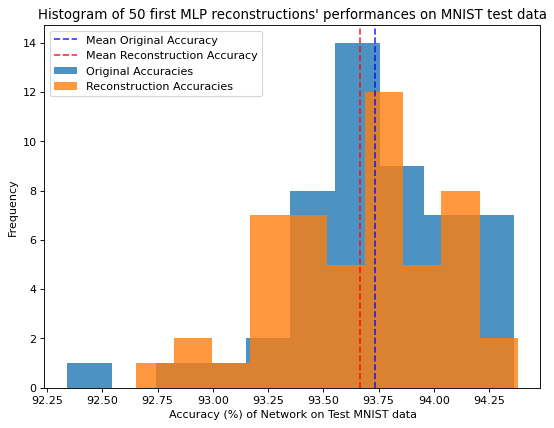

In [22]:
alpha = 0.8
plt.figure(figsize=(8, 6), dpi=80)
plt.title(f"Histogram of {n} first MLP reconstructions' performances on MNIST test data")
plt.hist(original_accuracies, alpha = alpha, label = f"Original Accuracies")
plt.axvline(np.mean(original_accuracies), linestyle = '--', alpha = alpha, label = f"Mean Original Accuracy", color = 'b')

plt.hist(generated_accuracies, alpha = alpha, label = f"Reconstruction Accuracies")
plt.axvline(np.mean(generated_accuracies), alpha = alpha, linestyle = '--', label = f"Mean Reconstruction Accuracy", color = 'r')
plt.xlabel(f"Accuracy (%) of Network on Test MNIST data")
plt.ylabel(f"Frequency")
plt.legend()
plt.savefig(f"Autoencoder_{n}_Distribution_Comparison_figure.png", format="png")
plt.show()

## To-do: 
* What are the Git-Rebasin distances between GAE inputs and outputs? 

# Diffusion

In [23]:
import math

# Trying very hard not to kill the kernel later on
import gc 
gc.collect

<function gc.collect(generation=2)>

In [24]:
# Does this break permutation symmetries in an important way? Not sure
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ResidualBlock2D(nn.Module):
    def __init__(self, channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        # self.norm = nn.BatchNorm2d(channels)
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, channels)
        )
        self.norm1 = nn.GroupNorm(16, channels) # 
        self.norm2 = nn.GroupNorm(16, channels)

    def forward(self, x, t_emb):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h += self.time_mlp(t_emb)[:, :, None, None]
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        # h = self.norm(h)
        return x + h

class UNet2D(nn.Module):
    def __init__(self, latent_dim, base_ch=32, time_emb_dim=16):
        super().__init__()
        # time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        # input projection (1 channel to base_ch)
        self.init_conv = nn.Conv2d(1, base_ch, kernel_size=3, padding=1)
        # down block
        self.down_block = ResidualBlock2D(base_ch, time_emb_dim)
        self.down_sample = nn.Conv2d(base_ch, base_ch * 2, kernel_size=4, stride=2, padding=1)
        # bottleneck
        self.mid_block = ResidualBlock2D(base_ch * 2, time_emb_dim)
        # up block
        self.up_sample = nn.ConvTranspose2d(base_ch * 2, base_ch, kernel_size=4, stride=2, padding=1)
        self.up_block = ResidualBlock2D(base_ch * 2, time_emb_dim)
        # final conv back to 1 channel
        self.final_conv = nn.Conv2d(base_ch * 2, 1, kernel_size=3, padding=1)

    def forward(self, x, t):
        # x: [B,1,N_nodes,latent_dim], t: [B]
        t_emb = self.time_mlp(t)
        # encode
        h0 = self.init_conv(x)                    # [B, base_ch, H, W]
        h1 = self.down_block(h0, t_emb)           # [B, base_ch, H, W]
        h2 = self.down_sample(h1)                 # [B, base_ch*2, H/2, W/2]
        # bottleneck
        h3 = self.mid_block(h2, t_emb)            # [B, base_ch*2, H/2, W/2]
        # decode
        h4 = self.up_sample(h3)                   # [B, base_ch, H, W]
        h4 = torch.cat([h4, h1], dim=1)           # [B, base_ch*2, H, W]
        h5 = self.up_block(h4, t_emb)             # [B, base_ch*2, H, W]
        return self.final_conv(h5)                # [B,1,H,W]

    
# -------------------------------------------------------
# 4) Diffusion Scheduler
# -------------------------------------------------------
class DiffusionScheduler:
    def __init__(self, timesteps=100, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        a = self.alphas_cumprod[t][:, None, None, None]
        return a.sqrt() * x_start + (1 - a).sqrt() * noise, noise

class LatentDiffusion2D(nn.Module):
    def __init__(self, unet, scheduler, gae = gae):
        super().__init__()
        self.unet = unet
        self.scheduler = scheduler
    def training_step(self, x0):
        # x0: [B,1,H,W]
        bsz = x0.size(0)
        t = torch.randint(0, self.scheduler.timesteps, (bsz,), device=x0.device)
        x_noisy, noise = self.scheduler.q_sample(x0, t)
        pred = self.unet(x_noisy, t)
        return F.mse_loss(pred, noise)

# These have already been imported, but doing it again to keep the names straight is good
from torch_geometric.loader import DataLoader as PyGDataLoader
from torch.utils.data import Dataset, DataLoader as TorchDataLoader

class GraphLatentDataset(Dataset):
    def __init__(self, gae, pyg_dataset, device):
        """
        Precomputes per-graph node-wise latents using the graph autoencoder.
        Returns tensors of shape [N_nodes, latent_dim] per graph.
        """
        self.device = device
        self.latents = []
        gae = gae.to(device)
        gae.eval()
        with torch.no_grad():
            for data in pyg_dataset:
                data = data.to(device)
                # encode yields [N_nodes, latent_dim]
                z = gae.encoder(data.x, data.edge_index, data.edge_attr.view(-1))
                self.latents.append(z.cpu())
    def __len__(self):
        return len(self.latents)
    def __getitem__(self, idx):
        # returns [N_nodes, latent_dim]
        return self.latents[idx]



## Training

In [25]:
# Create the latent dataset and a regular torch DataLoader:
# pyg_dataset is your MLPGraphDatasetNeuronsFromList
latent_dataset = GraphLatentDataset(gae, dataset, device)

# collate into tensor of shape [B, N_nodes, latent_dim]
def collate_latents(batch_list):
    return torch.stack(batch_list, dim=0)
    
latent_loader = TorchDataLoader(latent_dataset,
                                 batch_size=64,
                                 shuffle=True,
                                 collate_fn=collate_latents)

In [32]:
# Instantiate UNet2D and scheduler
unet2d = UNet2D(latent_dim = 64, base_ch=32, time_emb_dim=16).to(device)
scheduler = DiffusionScheduler(timesteps = 100) # <--- This should be 1000 timesteps, but using 1000 always kills the kernel
diffusion_model = LatentDiffusion2D(unet2d, scheduler).to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

save_every = 5  # save every n epochs
num_epochs = 25

print(f"UNet has {count_parameters(unet2d)} parameters")

UNet has 238225 parameters


In [59]:
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(1, num_epochs + 1):
    start = time.time()
    diffusion_model.train()
    total_loss = 0.0
    for batch_z in latent_loader:
        x0 = batch_z.unsqueeze(1).to(device)  # [B,1,N_nodes,latent_dim]
        loss = diffusion_model.training_step(x0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(latent_loader)
    end = time.time()
    print(f"Epoch {epoch:03d}/{num_epochs}, Loss: {avg_loss:.4f}, took {(end-start):.2f}s")

    # checkpoint saving
    if epoch % save_every == 0:
        ckpt = os.path.join(checkpoint_dir, f'diffusion_epoch_{epoch}.pth')
        torch.save(diffusion_model.state_dict(), ckpt)
        print(f"[Checkpoint] Saved model at epoch {epoch} to '{ckpt}'")

Epoch 001/25, Loss: 0.2822, took 86.52s
Epoch 002/25, Loss: 0.1296, took 86.02s
Epoch 003/25, Loss: 0.1030, took 85.86s
Epoch 004/25, Loss: 0.0796, took 86.05s
Epoch 005/25, Loss: 0.0713, took 86.06s
[Checkpoint] Saved model at epoch 5 to 'checkpoints/diffusion_epoch_5.pth'
Epoch 006/25, Loss: 0.0654, took 85.90s
Epoch 007/25, Loss: 0.0559, took 85.84s
Epoch 008/25, Loss: 0.0521, took 86.02s
Epoch 009/25, Loss: 0.0477, took 85.90s
Epoch 010/25, Loss: 0.0430, took 85.89s
[Checkpoint] Saved model at epoch 10 to 'checkpoints/diffusion_epoch_10.pth'
Epoch 011/25, Loss: 0.0422, took 85.68s
Epoch 012/25, Loss: 0.0416, took 85.92s
Epoch 013/25, Loss: 0.0380, took 85.99s
Epoch 014/25, Loss: 0.0374, took 85.98s
Epoch 015/25, Loss: 0.0363, took 85.92s
[Checkpoint] Saved model at epoch 15 to 'checkpoints/diffusion_epoch_15.pth'


KeyboardInterrupt: 



## April 25 U-Net tests
-------------------------




-------------------------
unet2d = UNet2D(latent_dim = 64, base_ch=64, time_emb_dim=32).to(device) <-- without attention

Epoch 001/5, Loss: 0.5436, took 301.20s
Epoch 002/5, Loss: 0.1626, took 300.22s
Epoch 003/5, Loss: 0.1218, took 300.19s
Epoch 004/5, Loss: 0.0996, took 299.38s
Epoch 005/5, Loss: 0.0812, took 299.27s
[Checkpoint] Saved model at epoch 5 to 'checkpoints/diffusion_epoch_5.pth'

-------------------------
### The best option - trained to 15 epochs on 25 April 
unet2d = UNet2D(latent_dim = 64, base_ch=32, time_emb_dim=16).to(device) <-- without attention
UNet has 238225 parameters

Epoch 001/5, Loss: 0.3175, took 127.36s
Epoch 002/5, Loss: 0.1406, took 122.03s
Epoch 003/5, Loss: 0.1068, took 124.81s
Epoch 004/5, Loss: 0.0824, took 123.49s
Epoch 005/5, Loss: 0.0706, took 125.25s
[Checkpoint] Saved model at epoch 5 to 'checkpoints/diffusion_epoch_5.pth'

-------------------------
unet2d = UNet2D(latent_dim = 64, base_ch=64, time_emb_dim=32).to(device) <-- with attention! 

Epoch 001/15, Loss: 1.4585, took 649.12s
Epoch 002/15, Loss: 0.9383, took 631.43s
Epoch 003/15, Loss: 0.4561, took 633.54s
Epoch 004/15, Loss: 0.1621, took 635.72s
Epoch 005/15, Loss: 0.1133, took 625.32s
[Checkpoint] Saved model at epoch 5 to 'checkpoints/diffusion_epoch_5.pth'
Epoch 006/15, Loss: 0.1037, took 632.36s
Epoch 007/15, Loss: 0.0970, took 646.77s
Epoch 008/15, Loss: 0.0798, took 637.07s
Epoch 009/15, Loss: 0.0707, took 646.86s
Epoch 010/15, Loss: 0.0712, took 648.27s
[Checkpoint] Saved model at epoch 10 to 'checkpoints/diffusion_epoch_10.pth'
Epoch 011/15, Loss: 0.0700, took 635.38s
Epoch 012/15, Loss: 0.0645, took 639.96s
Epoch 013/15, Loss: 0.0649, took 644.15s
Epoch 014/15, Loss: 0.0587, took 641.64s
Epoch 015/15, Loss: 0.0543, took 641.55s
[Checkpoint] Saved model at epoch 15 to 'checkpoints/diffusion_epoch_15.pth'

## Checkpoint loading

In [41]:
last_ckpt = os.path.join(checkpoint_dir, f'diffusion_epoch_{15}.pth')

# loaded_unet2d = UNet2D(latent_dim=64, base_ch=32, time_emb_dim=16).to(device)
loaded_unet2d = UNet2D(latent_dim = 64, base_ch=32, time_emb_dim=16).to(device)
loaded_scheduler = DiffusionScheduler()
loaded_model = LatentDiffusion2D(loaded_unet2d, loaded_scheduler).to(device)
loaded_model.load_state_dict(torch.load(last_ckpt))
loaded_model.eval()
print(f"Loaded checkpoint from '{last_ckpt}'")

unet2d = loaded_unet2d
scheduler = loaded_scheduler
diffusion_model = loaded_model.to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

with torch.no_grad(): 
    sample_z = next(iter(latent_loader))
    sample_x0 = sample_z.unsqueeze(1).to(device)
    loaded_loss = loaded_model.training_step(sample_x0)
    print(f"Loaded model loss on one sample batch: {loaded_loss.item():.4f}")

Loaded checkpoint from 'checkpoints/diffusion_epoch_15.pth'
Loaded model loss on one sample batch: 0.0390


In [40]:
start_epoch = 15
num_epochs = 10
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


unet2d = loaded_unet2d
scheduler = loaded_scheduler
diffusion_model = loaded_model.to(device)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

for epoch in range(1, num_epochs + 1):
    start = time.time()
    diffusion_model.train()
    total_loss = 0.0
    for batch_z in latent_loader:
        x0 = batch_z.unsqueeze(1).to(device)  # [B,1,N_nodes,latent_dim]
        loss = diffusion_model.training_step(x0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(latent_loader)
    end = time.time()
    print(f"Epoch {epoch:03d}/{num_epochs}, Loss: {avg_loss:.4f}, took {(end-start):.2f}s")

    # checkpoint saving
    if epoch % save_every == 0:
        ckpt = os.path.join(checkpoint_dir, f'diffusion_epoch_{epoch + start_epoch}.pth')
        torch.save(diffusion_model.state_dict(), ckpt)
        print(f"[Checkpoint] Saved model at epoch {epoch} to '{ckpt}'")

KeyboardInterrupt: 

# Generation and Evaluation

In [42]:
def sample_latents_2d(model, scheduler, num_graphs, N_nodes, latent_dim, device):
    """
    Reverse diffusion over 2D latents shape [num_graphs, 1, N_nodes, latent_dim]
    """
    model.eval()
    # start with pure noise of correct shape
    x = torch.randn(num_graphs, 1, N_nodes, latent_dim, device=device)
    for t in reversed(range(scheduler.timesteps)):
        t_batch = torch.full((num_graphs,), t, device=device, dtype=torch.long)
        eps_pred = model.unet(x, t_batch)
        a = scheduler.alphas[t]
        a_cum = scheduler.alphas_cumprod[t]
        b = scheduler.betas[t]
        # posterior mean
        mean = (1 / a.sqrt()) * (x - (b / (1 - a_cum).sqrt()) * eps_pred)
        if t > 0:
            noise = torch.randn_like(x)
            sigma = b.sqrt()
            x = mean + sigma * noise
        else:
            x = mean
    return x.squeeze(1)  # [num_graphs, N_nodes, latent_dim]


In [43]:
template = dataset[0].to(device) # <--- Template is a placeholder layout, (ie adjaceny matrix), not a leak
# Determine node count (H) and latent dimensionality (W)
N_nodes = template.x.size(0)
latent_dim = latent_loader.dataset.latents[0].size(1)

gc.collect
print(f"N_nodes: {N_nodes}, latent_dim: {latent_dim}")

N_nodes: 270, latent_dim: 64


## Generating Loop
To-Do: 
* Compare LDM git rebasin distances to real MLP examples
* Figure out how to use 1000 timesteps without crashing the kernel

In [47]:
m = 50
generated_mlp_acc = []
for i in range(m):
    sampled_z = sample_latents_2d(diffusion_model, scheduler, 1,
                              N_nodes, latent_dim, device)

    # z_graph: [N_nodes, latent_dim]
    edge_pred, node_pred = gae.decoder(sampled_z[0].to(device),
                                       template.edge_index,
                                       template.edge_attr.view(-1).to(device))
    
    rec_data = Data(x=node_pred.unsqueeze(1),
                    edge_index=template.edge_index,
                    edge_attr=edge_pred.unsqueeze(1))
    
    new_mlp = vgae_to_mlp(rec_data)
    acc = test_mlp(new_mlp, test_loader)
    generated_mlp_acc.append(acc)
    gc.collect
    
    print(f"Sample accuracy: {acc}%")
    
print(f"Generated MLP accuracies mean: {np.mean(generated_mlp_acc):.2f} and std: {np.std(generated_mlp_acc):.2f}")

Sample accuracy: 90.19%
Sample accuracy: 75.6%
Sample accuracy: 76.85%
Sample accuracy: 92.82%
Sample accuracy: 67.92%
Sample accuracy: 90.47%
Sample accuracy: 82.86%
Sample accuracy: 89.85%
Sample accuracy: 87.7%
Sample accuracy: 87.93%
Sample accuracy: 74.92%
Sample accuracy: 84.1%
Sample accuracy: 91.4%
Sample accuracy: 87.1%
Sample accuracy: 89.28%
Sample accuracy: 92.75%
Sample accuracy: 82.03%
Sample accuracy: 84.73%
Sample accuracy: 88.33%
Sample accuracy: 83.31%
Sample accuracy: 87.35%
Sample accuracy: 60.49%
Sample accuracy: 89.06%
Sample accuracy: 90.89%
Sample accuracy: 84.88%
Sample accuracy: 76.51%
Sample accuracy: 76.97%
Sample accuracy: 74.04%
Sample accuracy: 79.81%
Sample accuracy: 77.69%
Sample accuracy: 89.67%
Sample accuracy: 82.3%
Sample accuracy: 84.1%
Sample accuracy: 87.64%
Sample accuracy: 76.58%
Sample accuracy: 77.96%
Sample accuracy: 83.14%
Sample accuracy: 70.13%
Sample accuracy: 69.94%
Sample accuracy: 80.68%
Sample accuracy: 71.08%
Sample accuracy: 82.93%

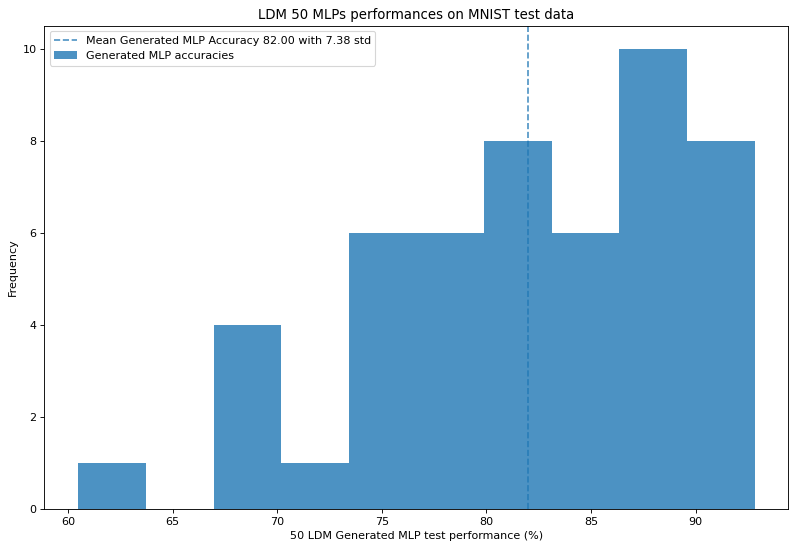

In [49]:
alpa = 0.8
plt.figure(figsize=(12, 8), dpi=80)
plt.title(f"LDM {m} MLPs performances on MNIST test data")
plt.hist(generated_mlp_acc, alpha = alpha, label = f"Generated MLP accuracies")
plt.axvline(np.mean(generated_mlp_acc), alpha = alpha, linestyle = '--', label = f"Mean Generated MLP Accuracy {(np.mean(generated_mlp_acc)):.2f} with {np.std(generated_mlp_acc):.2f} std")
plt.xlabel(f"{m} LDM Generated MLP test performance (%)")
plt.ylabel(f"Frequency")
plt.legend()
plt.savefig(f"LDM_{m}_Distribution_figure.png", format="png")
plt.show()

## Compare LDM generated MLPs vs Xavier random initialized MLPs
To-Do: 
* aggregate for many many generated and initialized MLPs, not just single samples

In [50]:
def first_epoch_training(model, epochs=1):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    hist = []
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            hist.append(loss.item())
            loss.backward()
            optimizer.step()
    
    return model, hist

In [51]:
sampled_z = sample_latents_2d(diffusion_model, scheduler, 1,
                              N_nodes, latent_dim, device)

edge_pred, node_pred = gae.decoder(sampled_z[0].to(device),
                                   template.edge_index,
                                   template.edge_attr.view(-1).to(device))
rec_data = Data(x=node_pred.unsqueeze(1),
                edge_index=template.edge_index,
                edge_attr=edge_pred.unsqueeze(1))
new_mlp = vgae_to_mlp(rec_data)

print(f"Generated Model (raw): {test_mlp(new_mlp, test_loader)}%")
trained_dumb_recon, recon_hist = first_epoch_training(new_mlp)
print(f"Generated Model After 1 epoch: {test_mlp(trained_dumb_recon, test_loader)}%")


# new_model = sample_first_mlp_from_batch(dumb)
old_model = MLP(init_type='xavier', seed=np.random.randint(10))
print(f"Random Init (raw): {test_mlp(old_model, test_loader)}%")
trained_dumb, hist = first_epoch_training(old_model)
print(f"Fresh Initialization After 1 epoch: {test_mlp(trained_dumb, test_loader)}%")

Generated Model (raw): 84.94%
Generated Model After 1 epoch: 93.49%
Random Init (raw): 13.02%
Fresh Initialization After 1 epoch: 91.06%


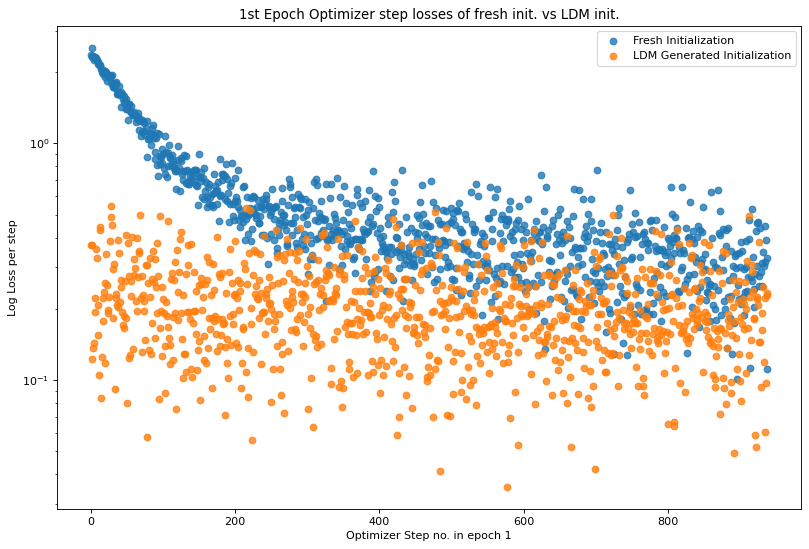

In [53]:
alpha = 0.8
x = np.linspace( 0, len(hist), len(hist))
plt.figure(figsize=(12, 8), dpi=80)
plt.title(f"1st Epoch Optimizer step losses of fresh init. vs LDM init.")
plt.scatter(x, hist, label = f"Fresh Initialization", alpha = alpha)
plt.scatter(x, recon_hist, label = f"LDM Generated Initialization", alpha = alpha)
plt.xlabel(f"Optimizer Step no. in epoch 1")
plt.ylabel(f"Log Loss per step")
plt.yscale('log')
plt.legend()
plt.savefig(f"LDM_vs_random_inits_logscale_figure.png", format="png")
plt.show()